# Natural language processing: spam detection

In [1]:
# Handle imports up-front
import regex as re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

## 1. Data loading

### 1.1. Load the data

In [2]:
# Read csv file into dataframe
data_df=pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv')

# Drop duplicates if any
data_df.drop_duplicates(inplace=True)
data_df.reset_index(inplace=True, drop=True)

### 1.2. Inspect the data

In [3]:
data_df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2369 entries, 0 to 2368
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2369 non-null   object
 1   is_spam  2369 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 21.0+ KB


### 1.3. Train-test split

In [5]:
# Separate features from labels
labels=data_df['is_spam']
features=data_df.drop('is_spam', axis=1)

# Encode the labels
encoded_labels=labels.apply(lambda x: 1 if x else 0).astype(int)

# Split the data into training and testing features and labels
training_features, testing_features, encoded_training_labels, encoded_testing_labels=train_test_split(
    features,
    encoded_labels,
    test_size=0.25,
    random_state=315
)

## 2. EDA

First, let's just take a look at how many 'spam' vs 'not spam' urls we have:

In [6]:
percent_spam=(sum(encoded_training_labels) / len(encoded_training_labels)) * 100
print(f'Training data is {percent_spam:.1f}% spam urls.')

Training data is 10.6% spam urls.


This is unbalanced, but not extremely so - we may not need to do anything with this information. But, it is good to keep it in mind as we work through EDA and modeling.

### 2.1. Text preprocessing

In [7]:
def preprocess_text(text):

    # Remove any character that is not a letter (a-z) or white space ( )
    text=re.sub(r'[^a-z ]', ' ', text)
    
    # Remove white spaces
    text=re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text=re.sub(r'\^[a-zA-Z]\s+', ' ', text)

    # Multiple white spaces into one
    text=re.sub(r'\s+', ' ', text.lower())

    # Remove tags
    text=re.sub('&lt;/?.*?&gt;',' &lt;&gt; ', text)

    # Remove 'http', 'https' and 'www'
    # text=re.sub('https', '', text)
    # text=re.sub('http', '', text)
    text=re.sub('www', '', text)

    return text.split()

training_features['url']=training_features['url'].apply(preprocess_text)
training_features.head()

,url
311,"[https, nytimes, com, us, into, the, wild, bus..."
2317,"[https, digg, cmail, com, t, ptuurik, vkjjhbly..."
1953,"[http, snarkmarket, com]"
1872,"[https, youtube, com, watch, d, u]"
1752,"[https, wired, com, story, amazon, shakes, sel..."


### 2.2. Lematization

In [ ]:
download('wordnet')
lemmatizer=WordNetLemmatizer()

download('stopwords')
stop_words=stopwords.words('english')

def lemmatize_text(words, lemmatizer=lemmatizer):
    tokens=[lemmatizer.lemmatize(word) for word in words]
    tokens=[word for word in tokens if word not in stop_words]
    tokens=[word for word in tokens if len(word) > 3]
    return tokens

training_features['url']=training_features['url'].apply(lemmatize_text)
training_features.head()

[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,url
311,"[http, nytimes, wild, removed, html]"
2317,"[http, digg, cmail, ptuurik, vkjjhbly]"
1953,"[http, snarkmarket]"
1872,"[http, youtube, watch]"
1752,"[http, wired, story, amazon, shake, self, driv..."


### 2.3. URL length distribution

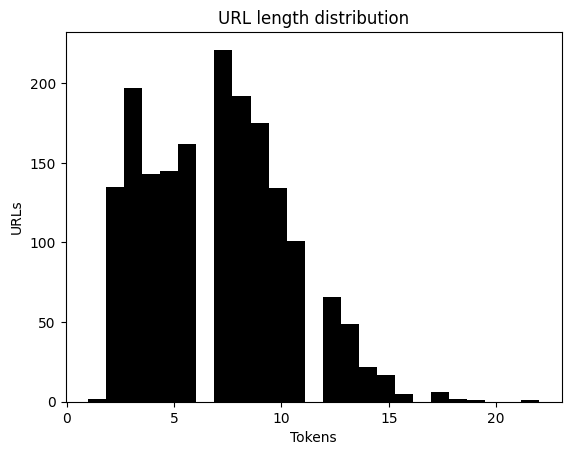

URL length mean: 7 tokens
URL length min: 1 tokens
URL length max: 22 tokens


In [9]:
# Get the lengths (in tokens)
lengths=[len(url) for url in training_features['url'].tolist()]

# Add it back to the data as a new feature
training_features['url_len']=lengths

plt.title('URL length distribution')
plt.xlabel('Tokens')
plt.ylabel('URLs')
plt.hist(lengths, bins=25, color='black')
plt.show()

print(f'URL length mean: {mean(lengths):.0f} tokens')
print(f'URL length min: {min(lengths):.0f} tokens')
print(f'URL length max: {max(lengths):.0f} tokens')

We have at least one URL with length zero after out text cleaning. Let's get rid of it.

In [10]:
# Add the labels back temporarily, so we can remove the corresponding label with url
training_features['target']=encoded_training_labels
training_features=training_features[training_features['url_len'] > 0]

# Re-separate the features and labels
encoded_training_labels=training_features['target']
training_features.drop(['target'], axis=1, inplace=True)

We also have some long urls, let's take a look at what they are and decide if we should exclude them.

In [11]:
training_features[training_features['url_len'] > 15]

,url,url_len
2159,"[http, washingtonpost, politics, court, suprem...",17
2142,"[http, ohio, news, ohio, university, professor...",16
219,"[http, judiciary, senate, press, release, chai...",17
1433,"[http, marketwatch, story, reason, stock, mark...",16
2320,"[http, washingtonpost, local, public, safety, ...",16
319,"[http, reuters, article, stock, weekahead, wal...",17
1866,"[http, washingtonpost, national, security, rus...",18
1724,"[http, section, live, update, protest, racial,...",16
2334,"[http, reuters, article, russia, putin, vote, ...",17
2077,"[http, blog, microsoft, blog, microsoft, launc...",17


These mostly look like news sites that pack a lot of article key words into the URL. You could accuse them of key-word stuffing for SEO/sensationalism, but these are not obviously 'junk' data points. Let's keep them in.

### 2.4. Vectorization

In [12]:
# Extract the tokenized URLs and join the individual lists
tokens_list=training_features['url']
tokens_list=[' '.join(tokens) for tokens in tokens_list]

# Vectorize the URLs using TF-IDF
vectorizer=TfidfVectorizer(max_features=5000, max_df=0.8, min_df=5)
encoded_training_features=vectorizer.fit_transform(tokens_list).toarray()

# Get the words from the vector model
feature_names=vectorizer.get_feature_names_out()

# Convert the training data word counts back into a dataframe
encoded_training_features=pd.DataFrame(encoded_training_features, columns=feature_names)
print(f'Encoded features shape: {encoded_training_features.shape}')

Encoded features shape: (1776, 386)


In [13]:
# Take a look...
encoded_training_features.head()

,abortion,account,action,administration,advertising,afghanistan,ahead,album,amazon,america,...,wordpress,work,worker,world,wwdc,year,york,youtu,youtube,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.702265,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.418558,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


### 2.4. Mean TF-IDF value distribution

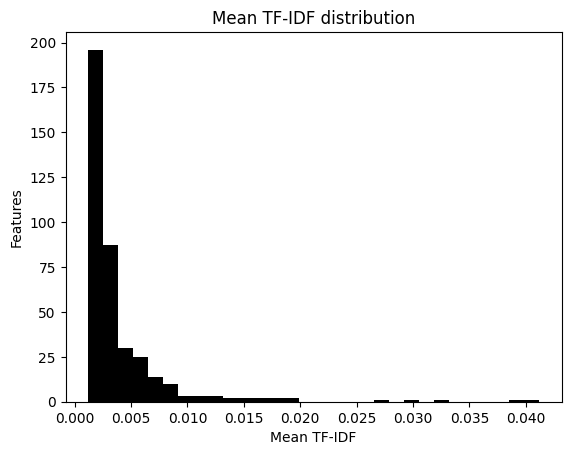

In [14]:
# Get the mean TF-IDF value for each feature
feature_means=encoded_training_features.mean().tolist()

plt.title('Mean TF-IDF distribution')
plt.xlabel('Mean TF-IDF')
plt.ylabel('Features')
plt.hist(feature_means, bins=30, color='black')
plt.show()

There are a lot of features with zero or very small TF-IDF values. This is not super surprising, this type of data is often very sparse. We could try re-running the vectorization with a higher *min_df* cutoff, but I think we should just leave it alone for now.

## 3. SVM model

### 3.1. Baseline model performance

In [15]:
cv_folds=7

# Instantiate the support vector machine classifier with defaults
baseline_model=SVC(class_weight='balanced')

# Cross-validate the default model on the encoded training data
scores=cross_val_score(
    baseline_model,
    encoded_training_features,
    encoded_training_labels,
    cv=cv_folds,
    n_jobs=-1
)

# Save the baseline cross-validation scores for later
cross_val_scores={
    'Model': ['Baseline']*cv_folds,
    'Score': list(scores)
}

print(f'Cross validation accuracy: {np.mean(scores)*100:.1f}+/-{np.std(scores)*100:.1f}%')

Cross validation accuracy: 83.9+/-1.4%


### 3.2. Hyperparameter optimization

In [16]:
# Set the hyperparameter search space
hyperparameters = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}

# Instantiate a new model
model=SVC(class_weight='balanced')

# Set up the grid search
grid=GridSearchCV(model, hyperparameters, scoring='accuracy', cv=cv_folds, n_jobs=-1)

# Run the search
optimization_results=grid.fit(encoded_training_features, encoded_training_labels)

print(f'Best hyperparameters: {grid.best_params_}')

Best hyperparameters: {'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}


In [17]:
# Cross-validate the model with the winning hyperparameters
optimized_model=SVC(**grid.best_params_, class_weight='balanced')

# Cross-validate the optimized model on the encoded training data
scores=cross_val_score(
    optimized_model,
    encoded_training_features,
    encoded_training_labels,
    cv=cv_folds,
    n_jobs=-1
)

# Save the optimized cross-validation scores for later
cross_val_scores['Model'].extend(['Optimized']*cv_folds)
cross_val_scores['Score'].extend(scores)

print(f'Cross validation accuracy: {np.mean(scores)*100:.1f}+/-{np.std(scores)*100:.1f}%')

Cross validation accuracy: 93.2+/-1.1%


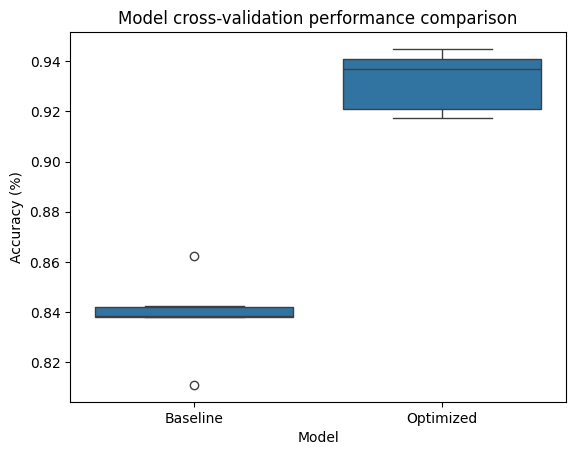

In [18]:
sns.boxplot(pd.DataFrame.from_dict(cross_val_scores), x='Model', y='Score')
plt.title('Model cross-validation performance comparison')
plt.ylabel('Accuracy (%)')
plt.show()

## 4. Model evaluation

### 4.1. Preprocess testing data

In [19]:
# Clean up the text
testing_features['url']=testing_features['url'].apply(preprocess_text)
testing_features['url']=testing_features['url'].apply(lemmatize_text)

# Get the lengths (in tokens)
lengths=[len(url) for url in testing_features['url'].tolist()]

# Add it back to the data as a new feature
testing_features['url_len']=lengths

# Exclude urls shorter than 15
testing_features[testing_features['url_len'] > 0]

# Extract the tokenized URLs and join the individual lists
tokens_list=testing_features['url']
tokens_list=[' '.join(tokens) for tokens in tokens_list]

encoded_testing_features=vectorizer.transform(tokens_list).toarray()

# Convert the testing data word counts back into a dataframe
encoded_testing_features=pd.DataFrame(encoded_testing_features, columns=feature_names)
print(f'Encoded features shape: {encoded_testing_features.shape}')

Encoded features shape: (593, 386)


### 4.2. Testing data performance

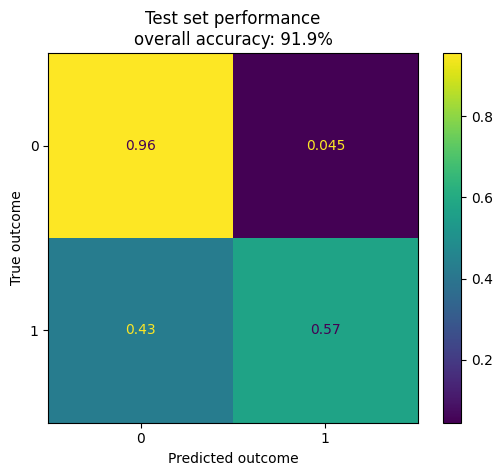

In [20]:
optimized_model.fit(encoded_training_features, encoded_training_labels)
predictions=optimized_model.predict(encoded_testing_features)

accuracy=accuracy_score(predictions, encoded_testing_labels)*100

# Plot the confusion matrix
cm=confusion_matrix(encoded_testing_labels, predictions, normalize='true')
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm)
_=cm_disp.plot()

plt.title(f'Test set performance\noverall accuracy: {accuracy:.1f}%')
plt.xlabel('Predicted outcome')
plt.ylabel('True outcome')
plt.show()